In [1]:
import pandas_datareader.data as web
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import warnings
import sys, os
import seaborn as sns


## Helper Functions

In [3]:
temp_stdout = None

# Disable
def blockPrint():
    global temp_stdout
    temp_stdout = sys.stdout
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    global temp_stdout
    sys.stdout = temp_stdout

In [4]:
def get_opt_model(returns, max_p, max_q, model_type, metric="AIC"):
    min_metric = float('inf')
    opt_p_q = []
    metric_mat = np.zeros((max_p, max_q))
    for p in range(1, max_p+1):
        for q in range(1, max_p+1):
            model = arch_model(returns, p=p, q=q,vol='model_type')
            model_fit = model.fit()
            if metric == "AIC":
                aic = model_fit.aic
                metric_mat[p-1, q-1] = round(aic, 1)
                if aic < min_metric:
                    min_metric = aic
                    opt_p_q = [p, q]
            elif metric == "BIC":
                bic = model_fit.bic
                metric_mat[p-1, q-1] = round(bic, 1)
                if bic < min_metric:
                    min_metric = bic
                    opt_p_q = [p, q]
                    
    return opt_p_q[0], opt_p_q[1], metric_mat

In [6]:
def heatmap(mat, model_type, metric):
    plt.clf()
    heatmap = sns.heatmap(mat, 
                          # cmap=color_scheme,
                          xticklabels=range(1, mat.shape[0]+1),
                          yticklabels=range(1, mat.shape[0]+1), 
                          vmin=np.min(mat), 
                          vmax=np.max(mat))
    heatmap.set_title(f"{metric} Heatmap")
    heatmap.set(xlabel = f"{model_type} q values", ylabel = "GARCH p values")
    plt.show()

In [7]:
def rolling_predictions(returns, opt_p, opt_q,model_type):
    warnings.filterwarnings('ignore')
    rolling_predictions = []
    test_size = 365*5

    for i in range(test_size):
        train = returns[:-(test_size-i)]
        model = arch_model(train, p=opt_p, q=opt_q,vol=model_type)
        model_fit = model.fit(disp='off')
        pred = model_fit.forecast(horizon=1)
        rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
        
    rolling_predictions = pd.Series(rolling_predictions, index=returns.index[-365*5:])

    plt.figure(figsize=(10,4))
    true, = plt.plot(returns[-365*5:])
    preds, = plt.plot(rolling_predictions)
    plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
    plt.legend(['Returns', 'Predicted Volatility'], fontsize=16)
    
    return rolling_predictions

In [10]:
def long_prediction(model, returns, num_test_days, opt_p, opt_q, rolling_preds):
    
    # THOUGHTS:
    # i don't think this is dont correctly since the 30-day and rolling forecast yield the same volatility
    # not sure what we are supposed to compare the 30-day forecast with?
    # how do we calculate the RMSE and MAE? like what are we using as a comparison volatility? 
    # if i'm not mistaken, the article from the link below says that volatility can't be measured point-wise
    # found this (not sure if its helpful): https://stats.stackexchange.com/questions/205562/evaluate-forecasting-ability-of-garch-models-with-rmse-and-mae 
    # quote from the link above: "The problem with such error metrics is that volatility is not an observable thing, and it depends on the model. 
    # Hence the error is not something well defined (compare what with what?)"

    
    train = returns[:-num_test_days]
    model = arch_model(train, p=opt_p, q=opt_q)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=num_test_days)
    test_dates = returns.index[len(returns)-num_test_days:]
    pred = pd.Series(np.sqrt(pred.variance.values[-1,:]), index=test_dates)
    plt.figure(figsize=(10,4))
    plt.plot(rolling_preds[len(returns)-num_test_days:], label=f"rolling prediction", linewidth=3)
    plt.plot(pred, label=f"{num_test_days}-day prediction", linewidth=1)
    plt.legend(loc ="lower left")
    plt.title(f'Volatility Prediction: {num_test_days} Days vs Rolling Prediction', fontsize=20)

In [11]:
def train_metrics(returns, model_type, metric, max_p, max_q):
    blockPrint()
    opt_p, opt_q, aic_mat = get_opt_model(returns, max_p, max_q, metric)
    opt_model = arch_model(returns, p=opt_p, q=opt_q, vol=model_type).fit()
    enablePrint()
    
    print(f"{metric} matrix: \n{aic_mat}")
    heatmap(aic_mat, model_type, metric)

    print(f"\n--- {model_type}({opt_p}, {opt_q}) ---")
    print(opt_model.summary())
    
    rolling_preds = rolling_predictions(returns, opt_p, opt_q)
    
    long_prediction(opt_model, returns, 30, opt_p, opt_q, rolling_preds)

# __________________________________________________________

## Load S&P 500 Data

In [12]:
start = datetime(2012, 11, 11)
end = datetime(2022, 11, 11)
spy = web.DataReader('SPY', 'yahoo', start=start, end=end)

#Calculating Log Returns and returning a series
spy['log_ret'] = np.log(spy.Close)-np.log(spy.Close.shift(1))
spy_log_ret = pd.Series(spy['log_ret']).dropna()

#Calculating Returns and returning a series
returns = 100 * spy.Close.pct_change().dropna()

spy_log_ret


Date
2012-11-13   -0.003478
2012-11-14   -0.013591
2012-11-15   -0.001693
2012-11-16    0.004925
2012-11-19    0.020037
                ...   
2022-11-07    0.009520
2022-11-08    0.005381
2022-11-09   -0.020817
2022-11-10    0.053497
2022-11-11    0.009632
Name: log_ret, Length: 2518, dtype: float64

## Load S&P 500 Futures (E-Mini) Data

In [19]:
df_futures = pd.read_csv("FuturesData.csv")
df_futures = df_futures[['Date', 'Price', 'Change %']]

#Calculate Returns and return a series
df_futures['Change %'] = [float(x.strip('%')) for x in df_futures['Change %']]
df_futures['Date'] = pd.to_datetime(df_futures['Date'])
futures_returns = df_futures["Change %"]
futures_returns.index = df_futures['Date']
futures_returns = futures_returns.sort_index(ascending=True)

#Set Index of Dataframe as Date in ascending order
df_futures = df_futures.set_index('Date')
df_futures= df_futures.sort_index(ascending=True)

#Convert Price to a float
df_futures['Price']=df_futures['Price'].str.replace(',','').astype(float)

#Compute log returns and return a series
df_futures['log_ret'] = np.log(df_futures.Price)-np.log(df_futures.Price.shift(1))
futures_log_ret = pd.Series(df_futures['log_ret']).dropna()




## Plot SPY Data

/Users/alexanderlerner/opt/anaconda3/envs/s207/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


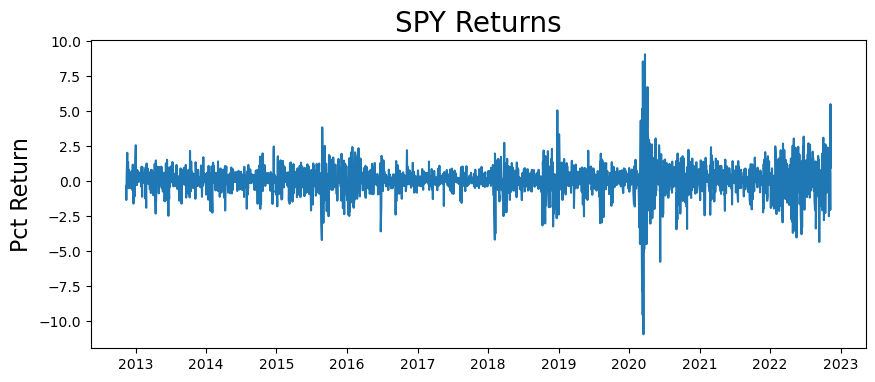

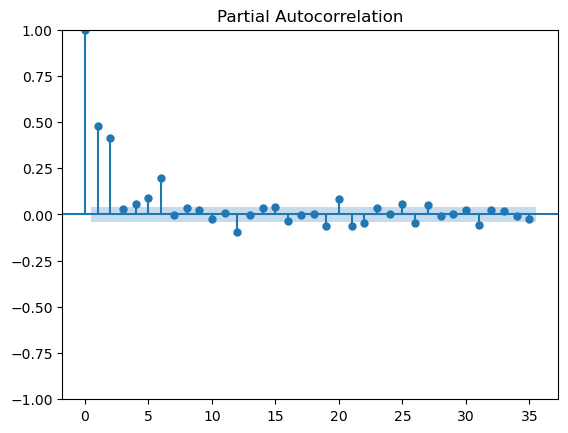

In [14]:
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Pct Return', fontsize=16)
plt.title('SPY Returns', fontsize=20)
plot_pacf(returns**2)
plt.show()

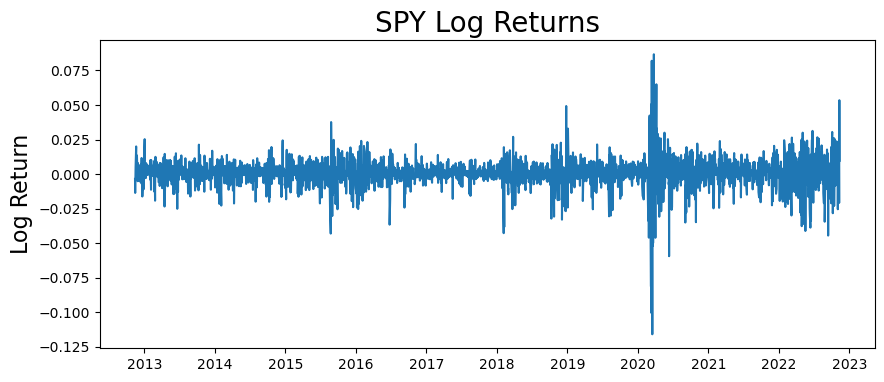

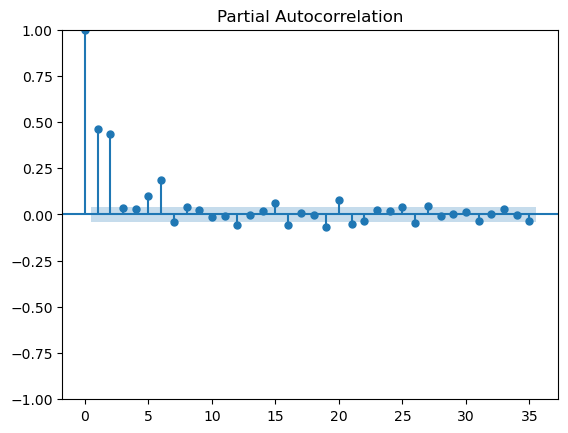

In [15]:
plt.figure(figsize=(10,4))
plt.plot(spy_log_ret)
plt.ylabel('Log Return', fontsize=16)
plt.title('SPY Log Returns', fontsize=20)
plot_pacf(spy_log_ret**2)
plt.show()

## Plot Futures Data

#### Futures Returns

/Users/alexanderlerner/opt/anaconda3/envs/s207/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


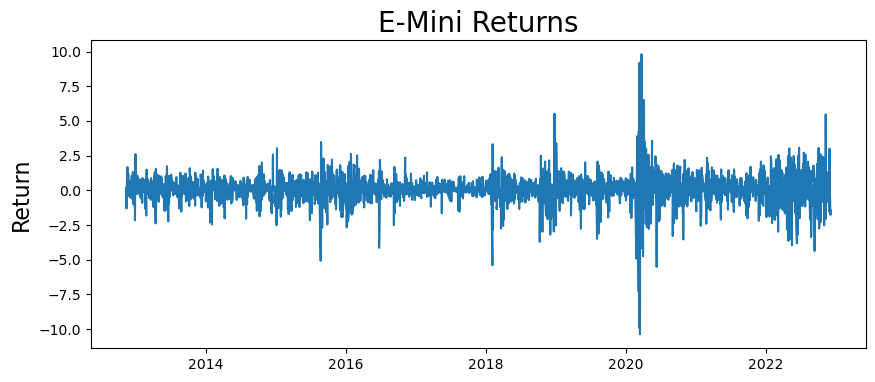

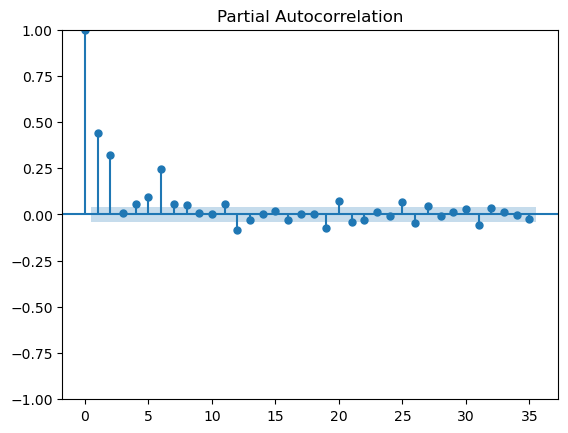

In [20]:
plt.figure(figsize=(10,4))
plt.plot(futures_returns)
plt.ylabel('Return', fontsize=16)
plt.title('E-Mini Returns', fontsize=20)
plot_pacf(futures_returns**2)
plt.show()

#### Futures Log Returns

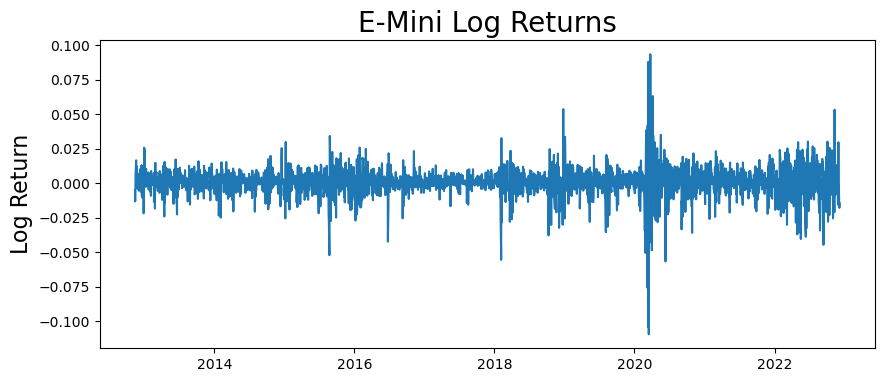

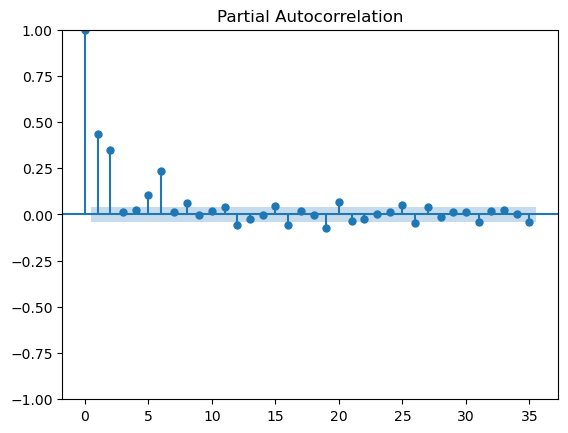

In [16]:
plt.figure(figsize=(10,4))
plt.plot(futures_log_ret)
plt.ylabel('Log Return', fontsize=16)
plt.title('E-Mini Log Returns', fontsize=20)
plot_pacf(futures_log_ret**2)
plt.show()

## Analyze Data: GARCH

### GARCH AIC & BIC

AIC matrix: 
[[6261.5 6263.5 6265.5 6267.5 6269.5]
 [6263.2 6264.3 6266.3 6268.3 6270.3]
 [6264.4 6266.4 6267.4 6269.4 6270.6]
 [6266.4 6265.4 6267.  6268.8 6268.1]
 [6268.4 6267.4 6269.  6270.8 6270.1]]


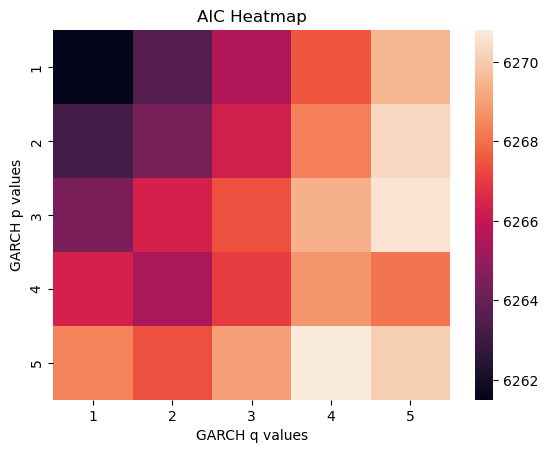


--- GARCH(1, 1) ---
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3126.76
Distribution:                  Normal   AIC:                           6261.52
Method:            Maximum Likelihood   BIC:                           6284.84
                                        No. Observations:                 2518
Date:                Wed, Dec 07 2022   Df Residuals:                     2517
Time:                        08:34:38   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0855  1.399e-02      6.111

KeyboardInterrupt: 

In [11]:
train_metrics(returns=returns, model_type="GARCH", metric="AIC", max_p=5, max_q=5)

BIC matrix: 
[[6284.8 6292.7 6300.5 6308.3 6316.2]
 [6292.3 6299.3 6307.1 6314.9 6322.7]
 [6299.4 6307.2 6314.1 6321.9 6328.9]
 [6307.3 6312.  6319.4 6327.1 6332.2]
 [6315.1 6319.9 6327.3 6334.9 6340. ]]


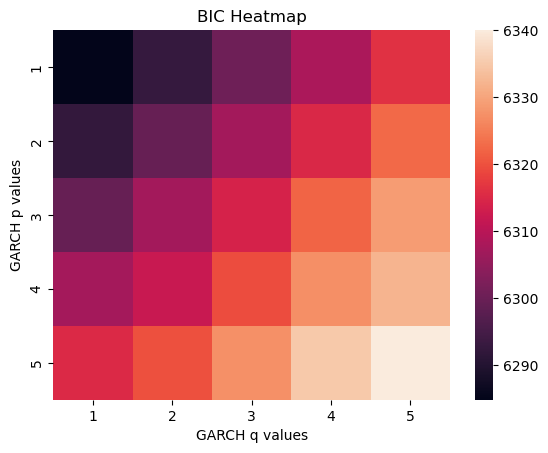


--- GARCH(1, 1) ---
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3126.76
Distribution:                  Normal   AIC:                           6261.52
Method:            Maximum Likelihood   BIC:                           6284.84
                                        No. Observations:                 2518
Date:                Wed, Dec 07 2022   Df Residuals:                     2517
Time:                        08:35:10   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0855  1.399e-02      6.111

KeyboardInterrupt: 

In [12]:
train_metrics(returns=returns, model_type="GARCH", metric="BIC", max_p=5, max_q=5)

### EGARCH AIC & BIC

AIC matrix: 
[[6261.5 6263.5 6265.5 6267.5 6269.5]
 [6263.2 6264.3 6266.3 6268.3 6270.3]
 [6264.4 6266.4 6267.4 6269.4 6270.6]
 [6266.4 6265.4 6267.  6268.8 6268.1]
 [6268.4 6267.4 6269.  6270.8 6270.1]]


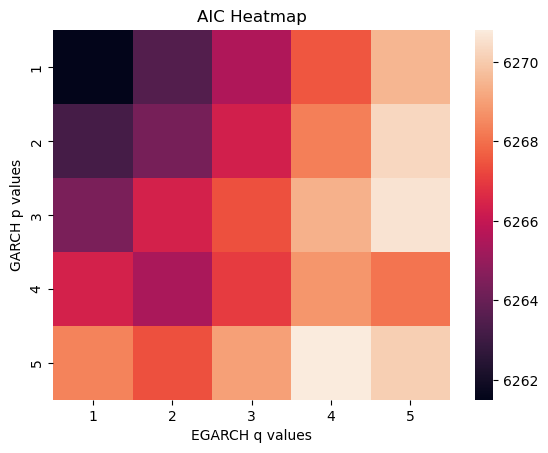


--- EGARCH(1, 1) ---
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -3137.23
Distribution:                  Normal   AIC:                           6282.47
Method:            Maximum Likelihood   BIC:                           6305.79
                                        No. Observations:                 2518
Date:                Wed, Dec 07 2022   Df Residuals:                     2517
Time:                        08:35:31   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0957  1.435e-02      6.66

KeyboardInterrupt: 

In [13]:
train_metrics(returns=returns, model_type="EGARCH", metric="AIC", max_p=5, max_q=5)

BIC matrix: 
[[6284.8 6292.7 6300.5 6308.3 6316.2]
 [6292.3 6299.3 6307.1 6314.9 6322.7]
 [6299.4 6307.2 6314.1 6321.9 6328.9]
 [6307.3 6312.  6319.4 6327.1 6332.2]
 [6315.1 6319.9 6327.3 6334.9 6340. ]]


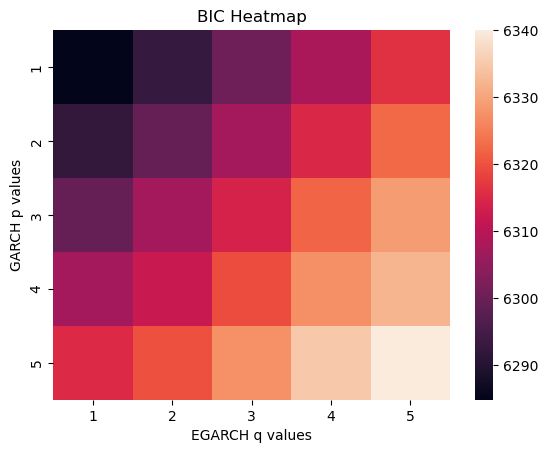


--- EGARCH(1, 1) ---
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -3137.23
Distribution:                  Normal   AIC:                           6282.47
Method:            Maximum Likelihood   BIC:                           6305.79
                                        No. Observations:                 2518
Date:                Wed, Dec 07 2022   Df Residuals:                     2517
Time:                        08:35:58   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0957  1.435e-02      6.66

KeyboardInterrupt: 

In [14]:
train_metrics(returns=returns, model_type="EGARCH", metric="BIC", max_p=5, max_q=5)

# __________________________________________________________

## Analyze Futures Data: GARCH

### GARCH AIC & BIC

AIC matrix: 
[[6351.  6353.  6355.  6357.  6359. ]
 [6352.2 6353.4 6355.4 6357.4 6359.4]
 [6353.4 6355.4 6357.6 6359.6 6361.6]
 [6353.6 6352.7 6353.2 6355.1 6354.7]
 [6355.6 6354.7 6355.2 6357.1 6356.7]]


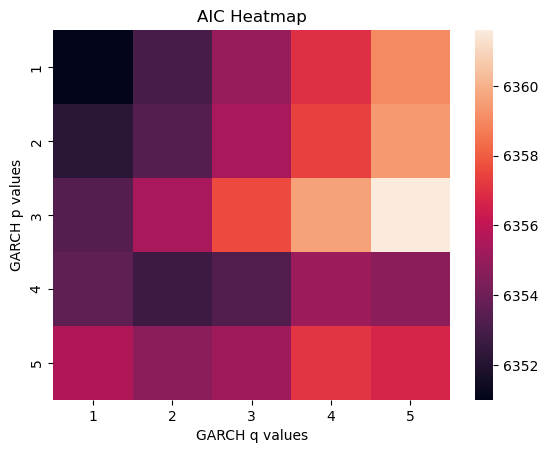


--- GARCH(1, 1) ---
                     Constant Mean - GARCH Model Results                      
Dep. Variable:               Change %   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3171.48
Distribution:                  Normal   AIC:                           6350.96
Method:            Maximum Likelihood   BIC:                           6374.36
                                        No. Observations:                 2563
Date:                Wed, Dec 07 2022   Df Residuals:                     2562
Time:                        08:36:20   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0900  1.407e-02      6.396

KeyboardInterrupt: 

In [17]:
train_metrics(returns=returns_futures, model_type="GARCH", metric="AIC", max_p=5, max_q=5)

BIC matrix: 
[[6374.4 6382.2 6390.1 6397.9 6405.8]
 [6381.4 6388.5 6396.3 6404.2 6412. ]
 [6388.5 6396.3 6404.3 6412.2 6420. ]
 [6394.5 6399.4 6405.8 6413.6 6419.1]
 [6402.4 6407.3 6413.7 6421.5 6426.9]]


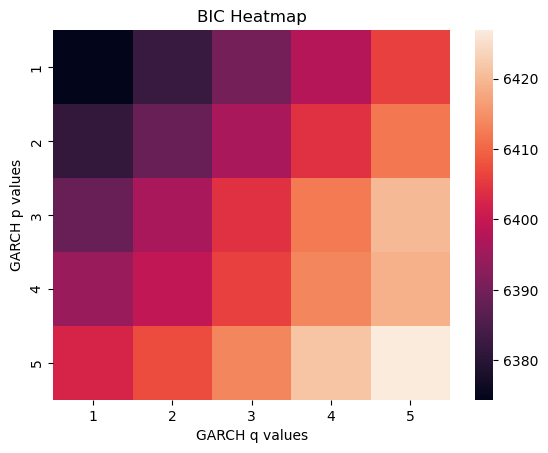


--- GARCH(1, 1) ---
                     Constant Mean - GARCH Model Results                      
Dep. Variable:               Change %   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3171.48
Distribution:                  Normal   AIC:                           6350.96
Method:            Maximum Likelihood   BIC:                           6374.36
                                        No. Observations:                 2563
Date:                Wed, Dec 07 2022   Df Residuals:                     2562
Time:                        08:36:33   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0900  1.407e-02      6.396

KeyboardInterrupt: 

In [18]:
train_metrics(returns=returns_futures, model_type="GARCH", metric="BIC", max_p=5, max_q=5)

### EGARCH AIC & BIC

AIC matrix: 
[[6351.  6353.  6355.  6357.  6359. ]
 [6352.2 6353.4 6355.4 6357.4 6359.4]
 [6353.4 6355.4 6357.6 6359.6 6361.6]
 [6353.6 6352.7 6353.2 6355.1 6354.7]
 [6355.6 6354.7 6355.2 6357.1 6356.7]]


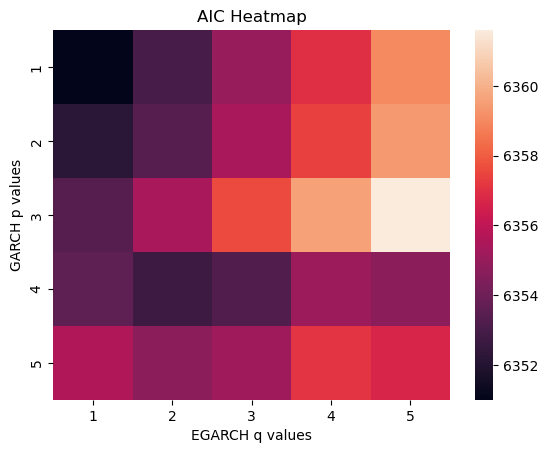


--- EGARCH(1, 1) ---
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:               Change %   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -3185.52
Distribution:                  Normal   AIC:                           6379.03
Method:            Maximum Likelihood   BIC:                           6402.43
                                        No. Observations:                 2563
Date:                Wed, Dec 07 2022   Df Residuals:                     2562
Time:                        08:36:45   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1063  1.478e-02      7.19

KeyboardInterrupt: 

In [19]:
train_metrics(returns=returns_futures, model_type="EGARCH", metric="AIC", max_p=5, max_q=5)

BIC matrix: 
[[6374.4 6382.2 6390.1 6397.9 6405.8]
 [6381.4 6388.5 6396.3 6404.2 6412. ]
 [6388.5 6396.3 6404.3 6412.2 6420. ]
 [6394.5 6399.4 6405.8 6413.6 6419.1]
 [6402.4 6407.3 6413.7 6421.5 6426.9]]


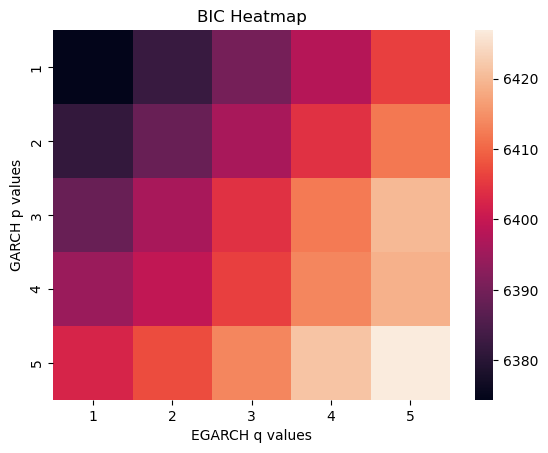


--- EGARCH(1, 1) ---
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:               Change %   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -3185.52
Distribution:                  Normal   AIC:                           6379.03
Method:            Maximum Likelihood   BIC:                           6402.43
                                        No. Observations:                 2563
Date:                Wed, Dec 07 2022   Df Residuals:                     2562
Time:                        08:37:07   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1063  1.478e-02      7.19

KeyboardInterrupt: 

In [20]:
train_metrics(returns=returns_futures, model_type="EGARCH", metric="BIC", max_p=5, max_q=5)

In [ ]:
rolling_predictions()